# Convolution Neural Network with MFCC features
Requires data from:
* `generate_data_py.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
# load up mfcc data
mfcc_labels = np.load(os.path.join("data", "labels.npy"))
mfcc_data   = np.load(os.path.join("data", "mfcc_data.npy"))
print(mfcc_labels.shape)
print(mfcc_data.shape)

(1049,)
(1049, 431, 12)


In [3]:
# Convert data to tensor compliant dataset
batchSize = 30;
mfccs_train, mfccs_test, labels_train, labels_test = train_test_split(mfcc_data, mfcc_labels, test_size=0.2, random_state=100)

mfccs_train_tensor  = torch.tensor(mfccs_train).unsqueeze(1)
mfccs_test_tensor   = torch.tensor(mfccs_test).unsqueeze(1)
labels_train_tensor = torch.tensor(labels_train)
labels_test_tensor  = torch.tensor(labels_test)

train_dataset = TensorDataset(mfccs_train_tensor, labels_train_tensor)
test_dataset  = TensorDataset(mfccs_test_tensor, labels_test_tensor)

train_loader = DataLoader(train_dataset, batch_size = batchSize, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = batchSize, shuffle = False)

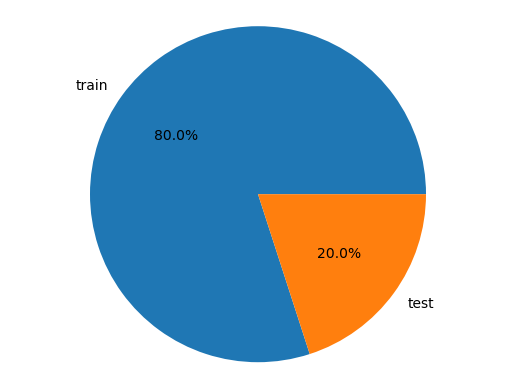

In [5]:
# Plot Train-Test Split
labels = ['train', 'test']
sizes = [mfccs_train.shape[0], mfccs_test.shape[0] ]  # Values for each section of the pie chart

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join("graphics", "train_test_split.png"), transparent=True)

In [4]:
# Define our CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# The Model
model = CNN()

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Train
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 4.4710
Epoch [2/10], Loss: 0.2238
Epoch [3/10], Loss: 0.1865
Epoch [4/10], Loss: 0.1216
Epoch [5/10], Loss: 0.1095
Epoch [6/10], Loss: 0.0630
Epoch [7/10], Loss: 0.1101
Epoch [8/10], Loss: 0.0698
Epoch [9/10], Loss: 0.0351
Epoch [10/10], Loss: 0.0253


In [7]:
# Evaluate
model.eval()
totalLabels = []
totalPredicted = []
with torch.no_grad():
    for t_inputs, t_labels in test_loader:
        outputs = model(t_inputs)
        _, predicted = torch.max(outputs.data, 1)
        totalLabels += t_labels
        totalPredicted += predicted
print(f"Test Accuracy: {accuracy_score(totalLabels, totalPredicted)}")
print(f"Test Precision: {precision_score(totalLabels, totalPredicted)}")
print(f"F1: {f1_score(totalLabels, totalPredicted)}")
print(f"Recall: {recall_score(totalLabels, totalPredicted)}")

Test Accuracy: 0.9380952380952381
Test Precision: 0.9603960396039604
F1: 0.9371980676328503
Recall: 0.9150943396226415


In [8]:
torch.save(model.state_dict(), os.path.join("models", "cnn_mfcc_model_testing.pth"))